<a href="https://colab.research.google.com/github/yufeng66/FutureGreeks/blob/master/SOA_talk_lognormal_scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Mon Aug 26 20:33:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   2021MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip3 install torch torchvision --upgrade


Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.2.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [0]:

import torch
print("torch version: ", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch version:  1.2.0
cuda


This is the generic black scholes call with pytorch

In [0]:
d=252      #days of simulation
K1, K2 = 6, 10
N1=2**K1   #batch count
N2=2**K2   #batch size
rf=0.02    #risk free rate
sigma=.16  #volatility
drift=0.0  #drift of the scenario

dt=torch.tensor(1/d,device=device)
sq_dt=torch.sqrt(dt)

s = torch.randn((N1,N2,d),device=device)
idx=torch.empty((N1,N2,d+1),device=device)
idx[:,:,0]=1
for i in range(d):
    idx[:,:,i+1]=idx[:,:,i]*torch.exp((drift-sigma**2/2)*dt+s[:,:,i]*sigma*sq_dt)

strike=1
payout=torch.clamp(idx[:,:,-1]-strike,min=0.0)


t=torch.linspace(0,1,d+1,device=device)
disc=torch.exp(-rf*t)
disc=disc.repeat(N1,N2,1)
pv_payout=payout*disc[:,:,-1]
                      
chg=idx[:,:,1:]*disc[:,:,1:]-idx[:,:,:-1]*disc[:,:,:-1]
#the chg is discounted to time zero already


In [0]:
t=torch.linspace(1-1/d,0,d,device=device)    #time to maturity
t=t.repeat(N1,N2,1)
s=idx[:,:,:-1].view(N1,N2,d,1)
t=t.view(N1,N2,d,1)
ts=torch.cat((t,s),3)

In [0]:
model_delta = torch.nn.Sequential(
    torch.nn.Linear(2, 32),
    torch.nn.Tanh(),
    torch.nn.Linear(32,32),
    torch.nn.Tanh(),
    torch.nn.Linear(32, 1),
    torch.nn.Sigmoid(),
)
model_delta = model_delta.to(device)

In [0]:
import time
optimizer = torch.optim.AdamW(model_delta.parameters(),lr=0.02,
                              weight_decay=1e-5,amsgrad=True)
t1=time.time()
for t in range(200):
    for i in range(N1):
        optimizer.zero_grad()
        delta=model_delta(ts[i])
        delta=delta.view(N2,d)
        asset_gl=torch.sum(delta*chg[i],dim=1)
        hedged_price=asset_gl-pv_payout[i]
        loss=hedged_price.var()
        loss.backward()
        optimizer.step()    
    if t%10==0: print(t,loss.item())
t2=time.time()
print(t2-t1)

0 0.00010645623115124181
10 1.8917238776339218e-05
20 1.5736128261778504e-05
30 1.4635813386121299e-05
40 1.6214138668146916e-05
50 1.6170130038517527e-05
60 1.6288167898892425e-05
70 1.49430952660623e-05
80 1.376220188831212e-05
90 1.3559897524828557e-05
100 1.4435530829359777e-05
110 1.5571717085549608e-05
120 1.4315387488750275e-05
130 1.3617403055832256e-05
140 1.3218044841778465e-05
150 1.3077152289042715e-05
160 1.3067437066638377e-05
170 1.3131846571923234e-05
180 1.3321170627023093e-05
190 1.3703132026421372e-05
84.00778126716614


In [0]:
import scipy.stats as si
def call_bs(S, K, r, q, T, sigma):
#    standard black scholes formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    call = (S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - \
            K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call
  
def delta_bs(S, K, r, q, T, sigma):
#    standard black scholes delta formula for call
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / \
            (sigma * np.sqrt(T))
    delta =  np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)        
    return delta

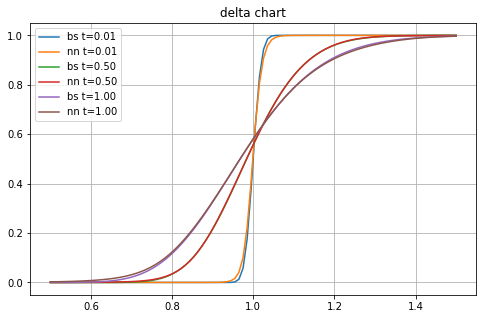

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plt.clf()
plt.cla()
plt.close()
plt.figure(figsize=(8,5))
plt.grid(True)

tl=[.01,.5,1.0]
for t in tl:
  s=torch.linspace(0.5,1.5,100,device=device)
  ts=torch.zeros((100,2),device=device)
  ts[:,0]=t
  ts[:,1]=s
  d_bs=delta_bs(s.cpu().numpy(),1,rf,0,t,sigma)
  d_nn=model_delta(ts)
  plt.plot(s.cpu().numpy(),d_bs,label="bs t="+ "%.2f" % t)
  plt.plot(s.cpu().numpy(),d_nn.cpu().view(100).detach().numpy(),
           label="nn t="+ "%.2f" % t)



plt.title("delta chart")
plt.legend()
#plt.savefig("test.svg")
plt.show()